In [1]:
import pandas as pd
import numpy as np
from jax import vmap
import jax.numpy as jnp
from jax.nn import softmax
import evofr as ef

In [2]:
# Getting data
raw_seq = pd.read_csv("../data/pango_location-variant-sequence-counts.tsv", sep="\t")
raw_seq = raw_seq[raw_seq.location == "USA"]
variant_frequencies = ef.VariantFrequencies(raw_seq)

In [3]:
# Defining model
mlr = ef.MultinomialLogisticRegression(tau=4.2)

In [4]:
# Defining inference method
inference_method = ef.InferFullRank(iters=50_000, lr=4e-3, num_samples=100)

In [5]:
# Fitting model
posterior = inference_method.fit(mlr, variant_frequencies)
samples = posterior.samples

Text(0, 0.5, 'loss')

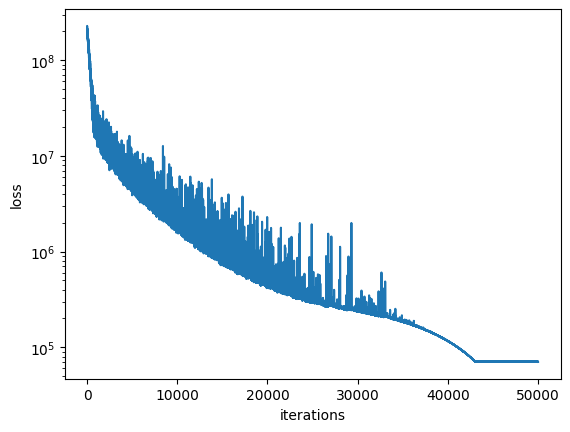

In [6]:
import matplotlib.pyplot as plt

plt.plot(posterior.samples["losses"])
plt.yscale("log")
plt.xlabel("iterations")
plt.ylabel("loss")

In [7]:
def forecast_frequencies(samples, mlr, forecast_L):
    """
    Use posterior beta to forecast posterior frequenicies.
    """
    
    # Making feature matrix for forecasting
    last_T = samples["freq"].shape[1]
    X = mlr.make_ols_feature(start=last_T, stop=last_T + forecast_L)
    
    # Posterior beta
    beta = jnp.array(samples["beta"])
    
    # Matrix multiplication by sample
    dot_by_sample = vmap(jnp.dot, in_axes=(None, 0), out_axes=0)
    logits = dot_by_sample(X, beta) # Logit frequencies by variant
    return softmax(logits, axis=-1)

forecast_L = 30
samples["freq_forecast"] = forecast_frequencies(samples, mlr, forecast_L)

In [8]:
ga = samples["ga"]

In [9]:
ga.shape

(100, 180)

In [10]:
type(ga)

jaxlib.xla_extension.DeviceArray

In [11]:
posterior.data.var_names[:10]

['B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.1.1.1',
 'BA.1.1.10',
 'BA.1.1.14',
 'BA.1.1.16',
 'BA.1.1.18',
 'BA.1.1.2',
 'BA.1.15']

In [12]:
ga_df = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples, posterior.data, ps=[0.8], name="USA", rel_to="BA.2")
)
ga_df.head(10)

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1.1.529,1.6197886,1.6314162,1.6109486
1,USA,BA.1,0.6491573,0.6555559,0.64386785
2,USA,BA.1.1,0.67485654,0.6762673,0.67309487
3,USA,BA.1.1.1,0.66055346,0.6810738,0.64071125
4,USA,BA.1.1.10,0.757043,0.7721609,0.74437594
5,USA,BA.1.1.14,0.6906616,0.705345,0.6756013
6,USA,BA.1.1.16,0.7298875,0.74041945,0.7181965
7,USA,BA.1.1.18,0.6428207,0.6477474,0.63685846
8,USA,BA.1.1.2,0.6316477,0.6508944,0.6157101
9,USA,BA.1.15,0.62645733,0.632679,0.62161255


In [13]:
ga_df.to_csv('growth_advantages.tsv', sep="\t")